In [12]:
import os
import glob
import ast
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# --- CONFIGURATION ---
input_dir  = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results"
output_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
os.makedirs(output_dir, exist_ok=True)

# find only train/test files, ignore gsm8k_X_*.csv
train_pattern = os.path.join(input_dir, "gsm8k_*_train_*.csv")
test_pattern  = os.path.join(input_dir, "gsm8k_*_test_*.csv")

train_files = [f for f in glob.glob(train_pattern) if not os.path.basename(f).startswith("gsm8k_X_")]
test_files  = [f for f in glob.glob(test_pattern)  if not os.path.basename(f).startswith("gsm8k_X_")]

# --- PASS 1: Collect last values per split ---
train_last = []
for path in tqdm(train_files, desc="Collecting train last-values"):
    df = pd.read_csv(path)
    for s in df["early_stop_correct_proportions"]:
        vals = ast.literal_eval(s)
        train_last.append(vals[-1])

test_last = []
for path in tqdm(test_files, desc="Collecting test last-values"):
    df = pd.read_csv(path)
    for s in df["early_stop_correct_proportions"]:
        vals = ast.literal_eval(s)
        test_last.append(vals[-1])

# compute per-split 20th/80th percentiles
p20_train, p80_train = np.percentile(train_last, [20, 80])
p20_test,  p80_test  = np.percentile(test_last,  [20, 80])

print(f"\nTrain thresholds → 20th: {p20_train:.4f} 80th: {p80_train:.4f}")
print(f"Test  thresholds → 20th: {p20_test:.4f} 80th: {p80_test:.4f}\n")

# --- PASS 2: Label & save per split ---
def label(val, p20, p80):
    if val >= p80:
        return "easy"
    elif val <= p20:
        return "hard"
    else:
        return "medium"

for path in tqdm(train_files + test_files, desc="Processing & saving files"):
    df = pd.read_csv(path)
    # choose thresholds based on split
    if "_train_" in os.path.basename(path):
        p20, p80 = p20_train, p80_train
    else:
        p20, p80 = p20_test, p80_test

    # label each row
    df["difficulty"] = df["early_stop_correct_proportions"].apply(
        lambda s: label(ast.literal_eval(s)[-1], p20, p80)
    )

    # save with new filename
    base = os.path.basename(path)
    new_name = base.replace(".csv", "_with_difficulty.csv")
    out_path = os.path.join(output_dir, new_name)
    df.to_csv(out_path, index=False)
    print(f"→ Saved: {out_path}")



Train thresholds → 20th: 0.1800 80th: 0.8400
Test  thresholds → 20th: 0.1400 80th: 0.8100



Processing & saving files:   0%|          | 0/89 [00:00<?, ?it/s]

→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_17_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_72_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_59_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_42_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_66_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_18_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_4_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty/gsm8k_Y_train_11_with_difficulty.csv
→ Saved: /n/home04/amuppidi/reaso

Loading files:   0%|          | 0/89 [00:00<?, ?it/s]

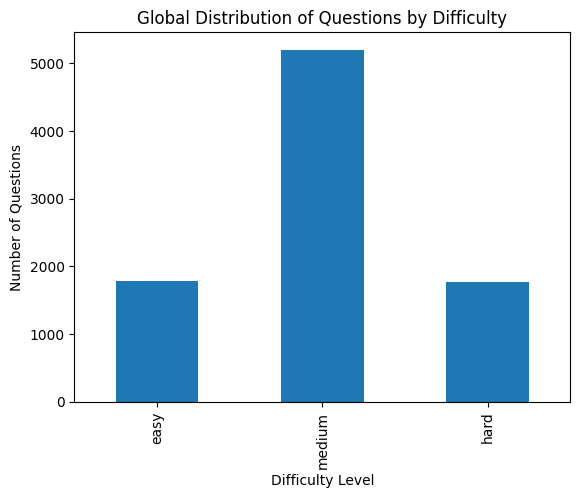

Sample question from each difficulty level:

--- EASY ---
Question ID: train_3999
Question Text: <｜User｜>Toby has two rectangles of cloth. The first is 4 inches wide and 5 inches tall. The second is 3 inches wide and 6 inches tall. How many more square inches is the area of the first compared to the second?<｜Assistant｜>

--- HARD ---
Question ID: test_1176
Question Text: <｜User｜>A teacher uses a 5-inch piece of chalk to write math equations on a chalkboard for his students. The teacher likes to conserve chalk, so he tries to only use 20% of the chalk each day. Since the teacher cannot write with a very small piece of chalk, he recycles the chalk when it is smaller than 2 inches. On Monday the teacher used a new piece of chalk. His students need extra help that day, so he ended up writing more than usual. He used up 45% of the chalk by the end of the day. If the teacher goes back to using only 20% of the chalk each day, how many days does he have before he has to recycle this piece?<｜As

/tmp/ipykernel_144624/1775223464.py:32: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  samples = combined_df.groupby('difficulty').apply(lambda g: g.sample(1)).reset_index(drop=True)


In [13]:
import os
import glob
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# Path to processed files
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"

# Collect all processed CSVs
all_files = glob.glob(os.path.join(input_dir, "*_with_difficulty.csv"))

# Read and concatenate all dataframes
dfs = []
for file in tqdm(all_files, desc="Loading files"):
    df = pd.read_csv(file)
    dfs.append(df)
combined_df = pd.concat(dfs, ignore_index=True)

# Compute global distribution
dist = combined_df['difficulty'].value_counts().reindex(['easy', 'medium', 'hard']).fillna(0)

# Plot distribution
plt.figure()
dist.plot(kind='bar')
plt.title("Global Distribution of Questions by Difficulty")
plt.xlabel("Difficulty Level")
plt.ylabel("Number of Questions")
plt.show()

# Sample one question from each category
samples = combined_df.groupby('difficulty').apply(lambda g: g.sample(1)).reset_index(drop=True)

print("Sample question from each difficulty level:\n")
for _, row in samples.iterrows():
    print(f"--- {row['difficulty'].upper()} ---")
    print(f"Question ID: {row['question_id']}")
    print(f"Question Text: {row['question_text']}\n")


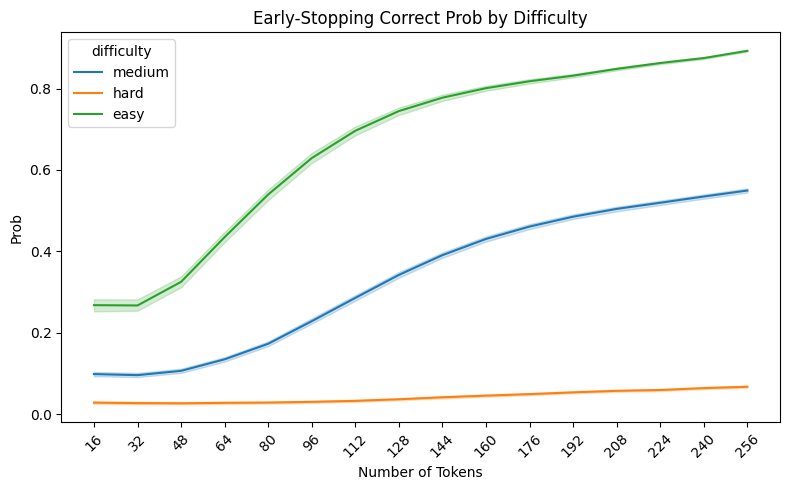

In [ ]:
import os
import glob
import ast
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
files = glob.glob(os.path.join(input_dir, "*_with_difficulty.csv"))

# long-form DataFrame: one row per question per bin
records = []
bins = [16 * i for i in range(1, 17)]  # [16, 32, …, 256]

for path in files:
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        vec = ast.literal_eval(row["early_stop_correct_proportions"])
        for tok, prob in zip(bins, vec):
            records.append({
                "difficulty": row["difficulty"],
                "tokens": tok,
                "proportion": prob
            })

long_df = pd.DataFrame(records)

# 3) Plot with Seaborn
plt.figure(figsize=(8, 5))
sns.lineplot(
    data=long_df,
    x="tokens",
    y="proportion",
    hue="difficulty",
)
plt.title("Early-Stopping Correct Prob by Difficulty")
plt.xlabel("Number of Tokens")
plt.ylabel("Prob")
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()


In [14]:
import os
import glob
import ast
import numpy as np
import pandas as pd

# — CONFIG —
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
pattern   = "*_with_difficulty.csv"

# token bins: 16, 32, …, 256
bins = [16 * i for i in range(1, 17)]

# collect vectors by (split, difficulty)
grouped = {}  # keys = (split, difficulty), value = list of vectors
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        split = row["split"]   # e.g. "train" or "test"
        diff  = row["difficulty"]
        vec   = ast.literal_eval(row["early_stop_correct_proportions"])
        grouped.setdefault((split, diff), []).append(vec)

# compute & print stats
for split in sorted({s for s, _ in grouped}):
    print(f"\n=== SPLIT: {split.upper()} ===")
    for diff in ["easy", "medium", "hard"]:
        vecs = grouped.get((split, diff), [])
        arr  = np.array(vecs)
        print(f"\n--- {diff.upper()} (n={arr.shape[0]}) ---")
        if arr.size == 0:
            print("  No data for this category.")
            continue

        mean_vec = arr.mean(axis=0)
        std_vec  = arr.std(axis=0)
        p25_vec  = np.percentile(arr, 25, axis=0)
        p75_vec  = np.percentile(arr, 75, axis=0)

        stats_df = pd.DataFrame({
            "tokens":       bins,
            "mean":         mean_vec,
            "std_dev":      std_vec,
            "25th_pctile":  p25_vec,
            "75th_pctile":  p75_vec
        })

        print(stats_df.to_string(index=False))



=== SPLIT: TEST ===

--- EASY (n=271) ---
 tokens     mean  std_dev  25th_pctile  75th_pctile
     16 0.240554 0.319319        0.000        0.430
     32 0.226974 0.294851        0.000        0.375
     48 0.272399 0.288748        0.020        0.455
     64 0.394133 0.303361        0.120        0.675
     80 0.500812 0.291988        0.260        0.770
     96 0.602177 0.267874        0.420        0.830
    112 0.665720 0.237740        0.560        0.850
    128 0.720627 0.202963        0.635        0.870
    144 0.759188 0.172520        0.680        0.880
    160 0.790332 0.145608        0.740        0.890
    176 0.804649 0.122871        0.750        0.890
    192 0.817638 0.102947        0.770        0.890
    208 0.839299 0.083648        0.795        0.900
    224 0.851513 0.068685        0.810        0.900
    240 0.866421 0.059296        0.830        0.910
    256 0.884576 0.046387        0.850        0.920

--- MEDIUM (n=760) ---
 tokens     mean  std_dev  25th_pctile  75th_pcti

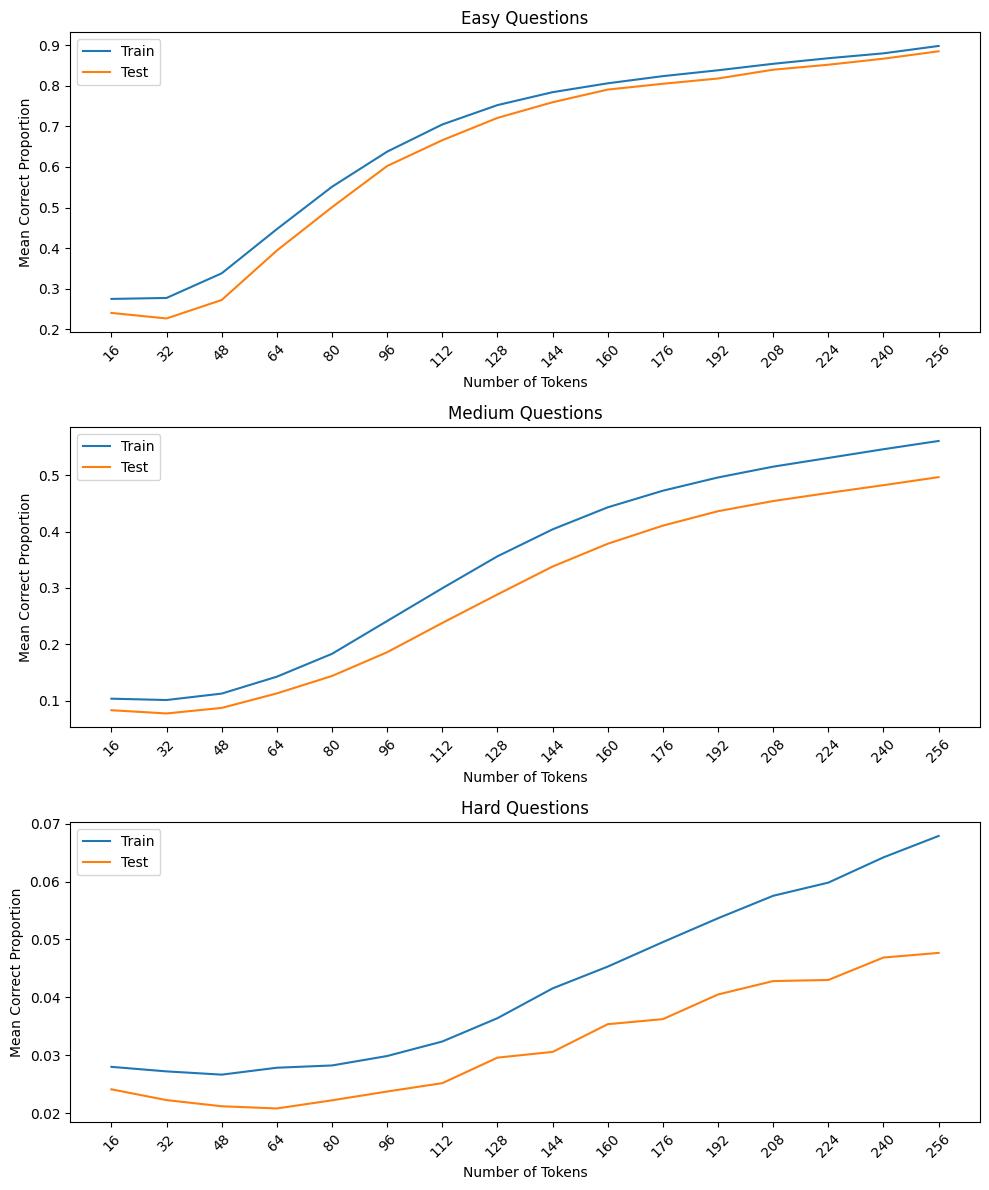

In [15]:
import os
import glob
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
pattern   = "*_with_difficulty.csv"

# Token bins: 16, 32, …, 256
bins = [16 * i for i in range(1, 17)]

# Prepare storage: data[difficulty][split] = list of vectors
difficulties = ["easy", "medium", "hard"]
splits       = ["train", "test"]
data = {d: {s: [] for s in splits} for d in difficulties}

# Load and group
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        # determine split key
        sp = row["split"]
        if sp.startswith("train"):
            split_key = "train"
        elif sp.startswith("test"):
            split_key = "test"
        else:
            continue
        diff = row["difficulty"]
        if diff in data:
            vec = ast.literal_eval(row["early_stop_correct_proportions"])
            data[diff][split_key].append(vec)

# Plot train vs test mean curve for each difficulty
plt.figure(figsize=(10, 12))
for i, diff in enumerate(difficulties, start=1):
    arr_train = np.array(data[diff]["train"])
    arr_test  = np.array(data[diff]["test"])
    mean_train = arr_train.mean(axis=0)
    mean_test  = arr_test.mean(axis=0)

    ax = plt.subplot(3, 1, i)
    ax.plot(bins, mean_train, label="Train")
    ax.plot(bins, mean_test,  label="Test")
    ax.set_title(f"{diff.title()} Questions")
    ax.set_xlabel("Number of Tokens")
    ax.set_ylabel("Mean Correct Proportion")
    ax.legend()
    ax.set_xticks(bins)
    ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()


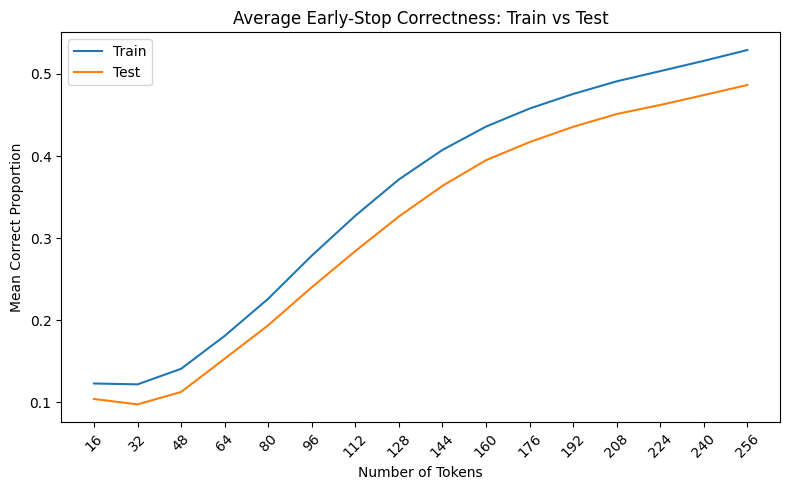

In [11]:
import os
import glob
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configuration
input_dir = "/n/home04/amuppidi/reasoning-scheduling/data/gsm8k_results_with_difficulty"
pattern = "*_with_difficulty.csv"

# Token bins: 16, 32, ..., 256
bins = [16 * i for i in range(1, 17)]

# Collect early-stop vectors by split
data = {'train': [], 'test': []}
for path in glob.glob(os.path.join(input_dir, pattern)):
    df = pd.read_csv(path)
    for _, row in df.iterrows():
        # Adjust this if your split column has suffixes
        split = row['split']  
        if split.startswith('train'):
            key = 'train'
        elif split.startswith('test'):
            key = 'test'
        else:
            continue
        vec = ast.literal_eval(row["early_stop_correct_proportions"])
        data[key].append(vec)

# Convert to numpy arrays
arr_train = np.array(data['train'])
arr_test  = np.array(data['test'])

# Compute mean vectors
mean_train = arr_train.mean(axis=0)
mean_test  = arr_test.mean(axis=0)

# Plot comparison
plt.figure(figsize=(8, 5))
plt.plot(bins, mean_train, label='Train')
plt.plot(bins, mean_test,  label='Test')
plt.title('Average Early-Stop Correctness: Train vs Test')
plt.xlabel('Number of Tokens')
plt.ylabel('Mean Correct Proportion')
plt.legend()
plt.xticks(bins, rotation=45)
plt.tight_layout()
plt.show()
